Instalacja wymaganych bibliotek

In [10]:
!pip install pandas numpy matplotlib tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tslearn import metrics
from scipy.spatial import distance

Odczytywanie i transformacja danych (temperatura - stopnie Celsiusza, ciśnienie - hPa, indeksy - datetime)

In [12]:
def read_data():
  press_data = pd.read_csv("https://raw.githubusercontent.com/bartekx43/WeatherAnomalyDetection/main/press.csv",
                          header=None, encoding="latin-1")
  temp_data = pd.read_csv("https://raw.githubusercontent.com/bartekx43/WeatherAnomalyDetection/main/temp.csv",
                          header=None, encoding="latin-1")
  wind_data = pd.read_csv("https://raw.githubusercontent.com/bartekx43/WeatherAnomalyDetection/main/wind.csv",
                          header=None, encoding="latin-1")
  
  data_combined = pd.concat([press_data, temp_data.iloc[:, 4], wind_data.iloc[:, 4]], axis=1)
  data_combined.columns = ["year", "month", "day", "hour", "pressure", "temperature", "wind speed"]
  
  transform_data(data_combined)

  return data_combined


def transform_data(data):
  data.index = pd.to_datetime(data[["year", "month", "day", "hour"]], errors='ignore')
  # data["pressure"] = data["pressure"] / 100
  # data["temperature"] = data["temperature"] - 273.15
  for param in ["pressure", "temperature", "wind speed"]:
    data[f"d_{param}"] = np.gradient(data[param])


Średni przebieg dzienny dla danego parametru `parameter` w przedziale `start_date` - `end-date`.
Wartości domyślne to cały zakres danych.

In [13]:
def day_course_mean(data, parameter, start_date="2019-01-01", end_date="2021-12-31"):
  selected_data = data[start_date:end_date]
  course_mean = selected_data.groupby("hour")[parameter].mean()

  return course_mean

Funkcja rysująca przebieg danych dla wybranego parametru - `draw`, odchylenie średniej wartości dziennej od średniej biegnącej z ostatnich 
`n` dni - `draw_deviation` oraz rysująca średni przebieg dzienny dla podanego okresu (domyślnie - cały zakres danych) - `draw_day_course`.

In [14]:
def draw(data, parameter, unit, n=14):
  plt.figure(figsize=(6,3))
  plt.plot(data[parameter].groupby([data.index.date]).mean(), label=parameter)
  plt.plot(data[parameter].groupby([data.index.date]).mean().rolling(n).mean(), label="rolling mean")
  plt.legend(loc="upper right")

  # plt.title(f"{parameter.capitalize()} course")
  plt.xlabel("date")
  plt.ylabel(f"{parameter} [{unit}]")
  plt.xticks([pd.to_datetime("2019-01-01"), pd.to_datetime("2020-01-01"), pd.to_datetime("2021-01-01"), pd.to_datetime("2021-12-31")])

  plt.show()


def draw_deviation(data, parameter, unit, n=14):
  plt.figure(figsize=(6, 3))
  plt.plot(abs(data[parameter].groupby([data.index.date]).mean() - data[parameter].groupby([data.index.date]).mean().rolling(n).mean()), marker="o", linestyle="")
  plt.legend(loc="upper right")

  # plt.title(f"Deviation of mean daily {parameter} from {n}-day mean")
  plt.xlabel("date")
  plt.ylabel(f"{parameter} deviation [{unit}]")

  plt.show()

def draw_day_course(data, parameter, unit, start_date="2019-01-01", end_date="2021-12-31"):
  # plt.figure(figsize=(4,4))
  day_course = day_course_mean(data, parameter, start_date, end_date)
  plt.plot(day_course)
  # plt.title(f"Mean daily {parameter} course")
  plt.xlabel("hour")
  plt.ylabel(f"{parameter} [{unit}]")
  plt.xticks(np.arange(0, 25, 4))

  plt.show()

Wczytanie danych i narysowanie wykresów dla poszczególnych parametrów

In [15]:
pd.set_option('precision', 2)
data = read_data()

In [16]:
print(len(data))

26304


In [17]:
data[['temperature', 'pressure', 'wind speed']].head()

,temperature,pressure,wind speed
2019-01-01 00:00:00,273.95,99023.19,0.91
2019-01-01 01:00:00,273.67,99008.44,1.44
2019-01-01 02:00:00,273.32,98921.06,1.78
2019-01-01 03:00:00,272.90,98808.81,2.41
2019-01-01 04:00:00,272.89,98653.25,2.81


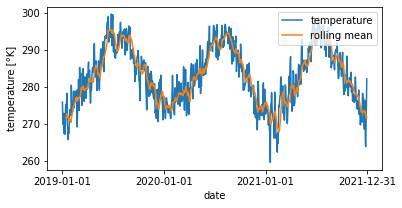

In [18]:
draw(data, "temperature", "°K")

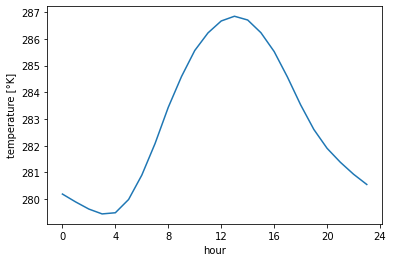

In [19]:
draw_day_course(data, "temperature", "°K")

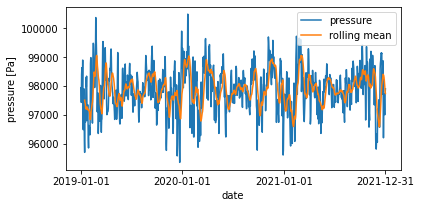

In [20]:
draw(data, "pressure", "Pa")

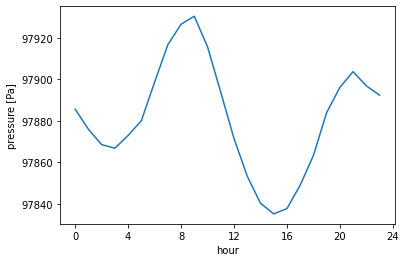

In [21]:
draw_day_course(data, "pressure", "Pa")

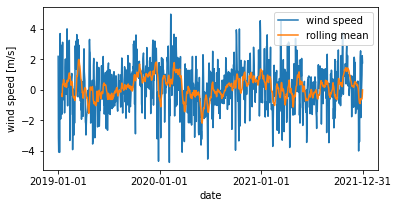

In [22]:
draw(data, "wind speed", "m/s")

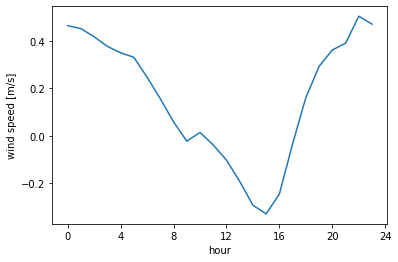

In [23]:
draw_day_course(data, "wind speed", "m/s")

Odchylenie średniej wartości dziennej od średniej z ostatnich 14 dni

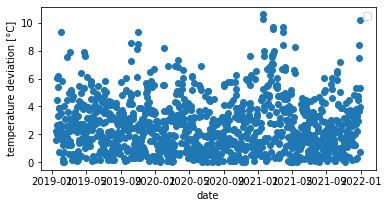

In [24]:
draw_deviation(data, "temperature", "°C")

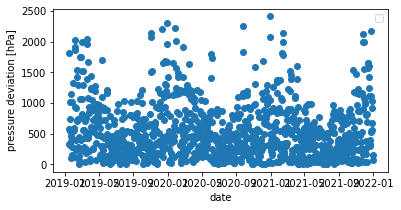

In [25]:
draw_deviation(data, "pressure", "hPa")

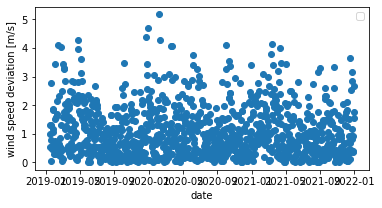

In [26]:
draw_deviation(data, "wind speed", "m/s")

Obliczanie odległości poszczególnych przebiegów od średniej miesięcznej `month_mean_analysis` lub biegnącej `sliding_mean_analysis` dla `n` dni z wykorzystaniem podanej miary odległości `measure_fun`.

In [27]:
def month_mean_analysis(data, parameter, measure_fun):
  results = []
  series_pairs = []

  for i in data.index.to_period("m").unique():
    month_mean = day_course_mean(data, parameter, i.start_time, i.end_time)
    month_data = data[i.start_time:i.end_time]
    for j in month_data.index.to_period("d").unique():
      day_course = data[j.start_time:j.end_time][parameter].to_numpy()
      fun_result = measure_fun(day_course, month_mean)
      results.append(fun_result)
      series_pairs.append((month_mean, day_course))

  return series_pairs, results

def sliding_mean_analysis(data, parameter, measure_fun, n):
  results = []
  series_pairs = []
  first = data.index.to_period("d").unique()[0].end_time
  
  for j in data.index.to_period("d").unique():
    start_date = j.start_time - pd.DateOffset(days=n)
    sliding_mean = day_course_mean(data, parameter, start_date, j.end_time if start_date > first + pd.DateOffset(days=n) else first + pd.DateOffset(days=n)).values
    day_course = data[j.start_time:j.end_time][parameter].to_numpy()
    fun_result = measure_fun(day_course, sliding_mean)
    results.append(fun_result)
    series_pairs.append((sliding_mean, day_course))

  return series_pairs, results

Rysowanie porównywanych przebiegów - `plot_series`, ich ścieżek w przypadku algorytmów takich jak DTW czy LCSS - `plot_path` oraz `n` skrajnych przykładów (najmniej lub najbardziej podobnych) - `plot_n_samples`, gdzie przekazujemy dane w krotce (odległość, para szeregów porównywanych)

In [28]:
def plot_series(series, subseries_color):
  plt.plot(range(len(series[0])), series[0], color="black")
  plt.plot(range(len(series[1])), series[1], color=subseries_color)


def plot_path(series, path, parameter, unit, with_path=True):
  plt.figure(figsize=(6,3))
  # plt.title("Optimal path between compared series")
  plt.ylabel(f"{parameter} [{unit}]")
  plt.xlabel("hour")
  # plt.xticks(np.arange(0, 25, 1))
  if with_path:
    for positions in path:
        plt.plot([positions[0], positions[1]], [series[1][positions[0]], series[0][positions[1]]], color="orange", linewidth=1.5)
  plt.plot(series[0], "black")
  plt.plot(series[1], "blue")
  plt.show()
        

def plot_samples(sorted_tuples, parameter, unit, first=True):
  fig, axs = plt.subplots(4, 4, figsize=(8,8), sharey=True, sharex=True)
  # fig.suptitle(f"{'Most' if first else 'Least'} similar courses with the mean")
  for ax in axs.flat:
    ax.set(xlabel='hour', ylabel=f"{parameter} [{unit}]")
  for ax in axs.flat:
    ax.label_outer()
  for i in range(4):
    for j in range(4):
      series = sorted_tuples[2*i+j if first else -(2*i+j)-1][1]
      axs[i, j].plot(series[0], color="black")
      axs[i, j].plot(series[1], color="blue")
  fig.show()

**Przykładowe wyniki**

1. Dowolny, wybrany niżej parametr (temperature, pressure, wind speed)

In [29]:
param = "pressure"
unit = "Pa"

1.1 DTW


In [30]:
series_pairs, results = sliding_mean_analysis(data, param, metrics.dtw_path, 14)
paths = [x[0] for x in results]
distances = [x[1] for x in results]
sorted_values = [x for x in sorted(zip(distances, series_pairs, paths))]

<ipython-input-30-ed104449aff1>:1: UserWarning: Discarding nonzero nanoseconds in conversion
  series_pairs, results = sliding_mean_analysis(data, param, metrics.dtw_path, 14)
<ipython-input-30-ed104449aff1>:1: UserWarning: Discarding nonzero nanoseconds in conversion
  series_pairs, results = sliding_mean_analysis(data, param, metrics.dtw_path, 14)


Przykłady przebiegów najbardziej oraz najmniej podobnych do przebiegu średniego z ostatnich 14 dni

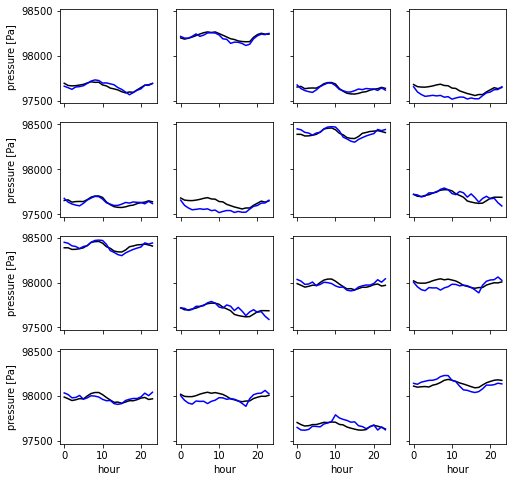

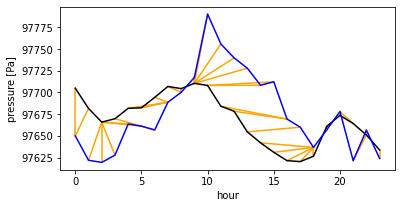

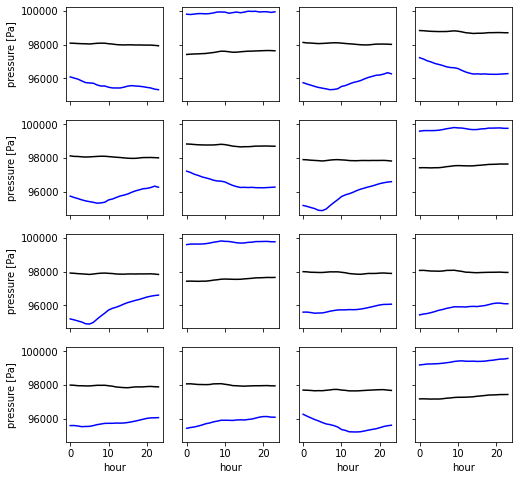

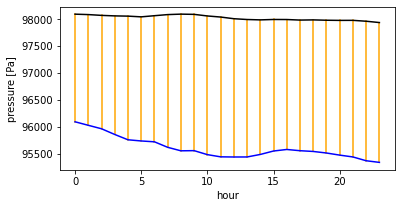

In [31]:
plot_samples(sorted_values, param, unit)

plot_path(sorted_values[8][1], sorted_values[8][2], param, unit)
# plot_path(sorted_values[9][1], sorted_values[9][2], param, unit)

plot_samples(sorted_values, param, unit, False)

plot_path(sorted_values[-1][1], sorted_values[-1][2], param, unit)

1.2 LCSS

In [32]:
series_pairs, results = sliding_mean_analysis(data, param, lambda x, y: metrics.lcss_path(x, y, eps=50), 14)
paths = [x[0] for x in results]
distances = [x[1] for x in results]
print(distances.count(0))
sorted_values = list(reversed([x for x in sorted(zip(distances, series_pairs, paths), key=lambda x: x[0])]))

<ipython-input-32-904eba661f40>:1: UserWarning: Discarding nonzero nanoseconds in conversion
  series_pairs, results = sliding_mean_analysis(data, param, lambda x, y: metrics.lcss_path(x, y, eps=50), 14)
<ipython-input-32-904eba661f40>:1: UserWarning: Discarding nonzero nanoseconds in conversion
  series_pairs, results = sliding_mean_analysis(data, param, lambda x, y: metrics.lcss_path(x, y, eps=50), 14)


632


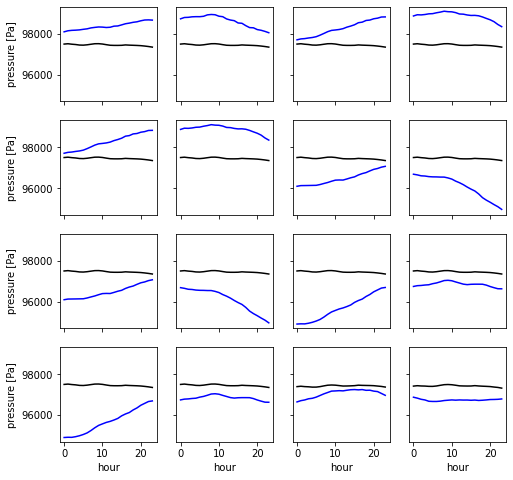

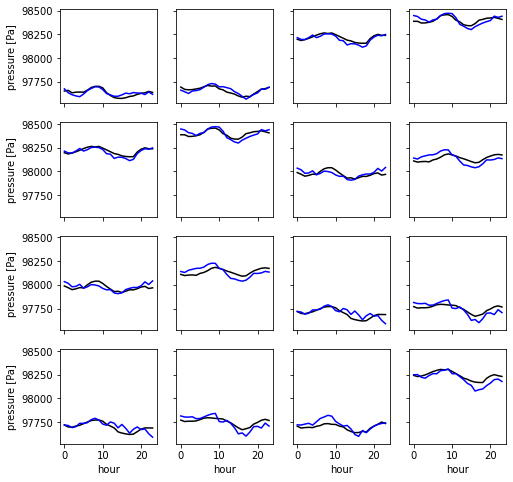

In [33]:
plot_samples(sorted_values, param, unit, False)

plot_samples(sorted_values, param, unit)

# for i in range(60,80):
  # plot_path(sorted_values[-(i+1)][1], sorted_values[-(i+1)][2], param, unit)
  # plot_path(sorted_values[i][1], sorted_values[i][2], param, unit)

1.3 Dystans euklidesowy

In [34]:
series_pairs, distances = sliding_mean_analysis(data, param, distance.euclidean, 14)
sorted_values = [x for x in sorted(zip(distances, series_pairs))]

<ipython-input-34-673d1c7e8417>:1: UserWarning: Discarding nonzero nanoseconds in conversion
  series_pairs, distances = sliding_mean_analysis(data, param, distance.euclidean, 14)


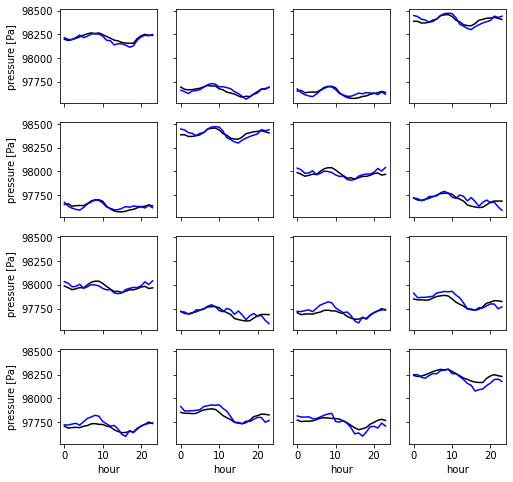

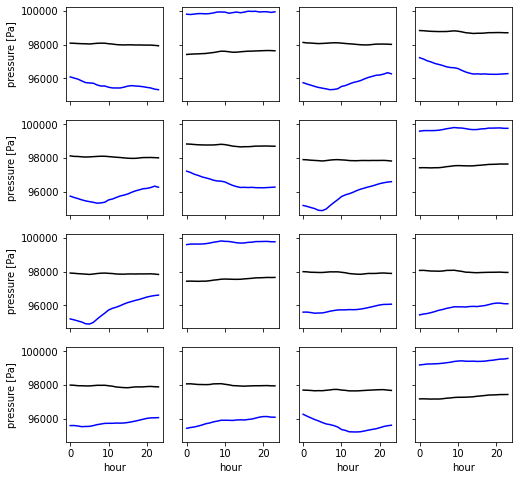

In [35]:
plot_samples(sorted_values, param, unit)
plot_samples(sorted_values, param, unit, False)
# for i in range(10):
  # plot_path(sorted_values[i][1], None, param, unit, False)
  # plot_path(sorted_values[-(i+1)][1], None, param, unit, False)

1.4 DTW na pochodnej przebiegu po czasie (brany pod uwagę wyłącznie kształt, bez offsetu)

In [36]:
param = "pressure"
unit = "Pa"

In [37]:
def ddtw(x, y):
  return metrics.dtw_path(np.gradient(x), np.gradient(y))
  
series_pairs, results = sliding_mean_analysis(data, param, ddtw, 14)
paths = [x[0] for x in results]
distances = [x[1] for x in results]
sorted_values = [x for x in sorted(zip(distances, series_pairs, paths))]

<ipython-input-37-ade06d5fd04d>:4: UserWarning: Discarding nonzero nanoseconds in conversion
  series_pairs, results = sliding_mean_analysis(data, param, ddtw, 14)


In [38]:
# for i in range(10):
  # plot_path(sorted_values[i][1], sorted_values[i][2], param, unit)
  # plot_path(sorted_values[-(i+1)][1], sorted_values[-(i+1)][2], param, unit)

2. Klasyfikacja

In [39]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def draw_measure_course(dists, indexes):
  # anomalies = [(indexes[i], dists[i][0]) if x == 1 else (indexes[i], 0) for i, x in enumerate(labels)]
  # if sum([x[1] for x in anomalies]) > 0:
  #   plt.scatter([i for i, a in anomalies if a > 0], [a for i, a in anomalies if a > 0])
  plt.figure(figsize=(6,3))
  plt.plot(indexes, dists, color='black')
  plt.xticks(rotation=30)
  plt.show()

def draw_anomalies(dists, indexes, labels):
  plt.figure(figsize=(6,3))
  anomalies = [(indexes[i], dists[i][0]) if x == 1 else (indexes[i], 0) for i, x in enumerate(labels)]
  if sum([x[1] for x in anomalies]) > 0:
    plt.scatter([i for i, a in anomalies if a > 0], [a for i, a in anomalies if a > 0])
  plt.plot(indexes, dists, color='black')
  plt.xticks(rotation=30)
  plt.show()

def draw_all_anomalies(dists, indexes, labels, preds):
  plt.figure(figsize=(6,3))
  labels = [2*x for x in labels]
  anomalies = [(indexes[i], dists[i][0], x[0]-x[1]) if x[0]+x[1] != 0 else (indexes[i], 0, 0) for i, x in enumerate(zip(labels, preds))]
  if sum([a for i, a, c in anomalies if c == 2]) > 0:
    plt.scatter([i for i, a, c in anomalies if a > 0 if c == 2], [a for i, a, c in anomalies if a > 0 if c == 2], c="orange")
  if sum([a for i, a, c in anomalies if c == 1]) > 0:
    plt.scatter([i for i, a, c in anomalies if a > 0 if c == 1], [a for i, a, c in anomalies if a > 0 if c == 1], c="green")
  if sum([a for i, a, c in anomalies if c == -1]) > 0:    
    plt.scatter([i for i, a, c in anomalies if a > 0 if c == -1], [a for i, a, c in anomalies if a > 0 if c == -1], c="red")
  plt.plot(indexes, dists, color='black')
  plt.xticks(rotation=30)
  plt.show()

def detect_anomalies(data, parameter, fun, classifier, draw=False):
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)
  if fun == metrics.dtw_path or fun == ddtw:
    dists = [x[1] for x in result_temp]
  else:
    dists = [x for x in result_temp]
  
  dates = [i.to_timestamp() for i in data.index.to_period("d").unique()]

  # if draw:
  #   draw_measure_course(dists, dates)
  
  dists = normalize(np.array(dists).reshape(-1,1), axis=0).tolist()
  dist_avg_n = 30
  # dist_avg = [np.mean(dists[0 if i <= dist_avg_n else i-dist_avg_n:i+1]) for i in range(len(dists))]
  dist_avg = [np.mean(dists[0 if i <= dist_avg_n else i-dist_avg_n: len(dists) if i >= len(dists)-dist_avg_n else i+dist_avg_n]) for i in range(len(dists))]

  two_years_n = 365 + 366

  train = [[date.month,dist[0]] for date, dist in zip(dates[:two_years_n], dists[:two_years_n])]
  train_labels = [0 if d[0] < 2*dist_avg[i] else 1 for i, d in enumerate(dists[:two_years_n])]
  indtr = dates[:two_years_n]

  test = [[date.month,dist[0]] for date, dist in zip(dates[two_years_n:], dists[two_years_n:])]
  test_labels = [0 if d[0] < 2*dist_avg[i] else 1 for i, d in enumerate(dists[two_years_n:])]
  indtest = dates[two_years_n:]

  if draw:
    draw_anomalies(dists[:two_years_n], indtr, train_labels)

  classifier.fit(train, train_labels)
  predictions = classifier.predict(test)

  if draw:
    # draw_anomalies(dists[two_years_n:], indtest, predictions)
    draw_anomalies(dists[two_years_n:], indtest, test_labels)
  
  if draw:
    draw_all_anomalies(dists[two_years_n:], indtest, test_labels, predictions)

  score = f1_score(test_labels, predictions)

  return dates[two_years_n:], predictions, test_labels, score

Wybór parametru oraz klasyfikatora

In [40]:
fun = distance.euclidean
# fun = metrics.dtw_path
# fun = ddtw


Klasyfikacja anomalii w zbiorze testowym za pomocą różnych miar odległości

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


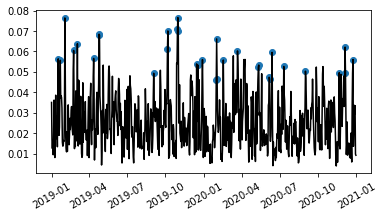

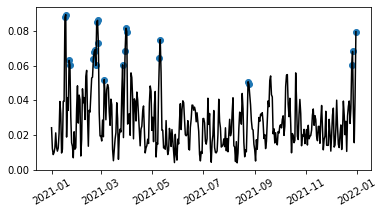

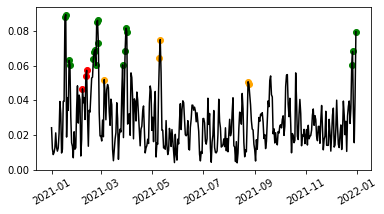

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


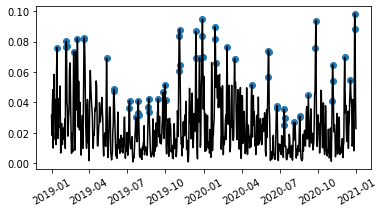

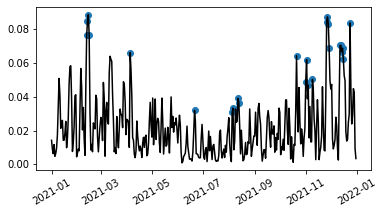

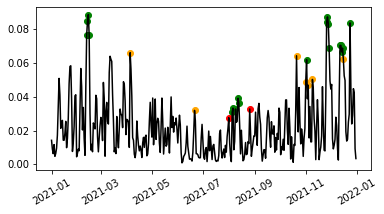

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


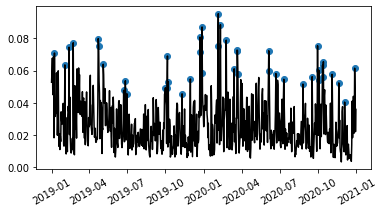

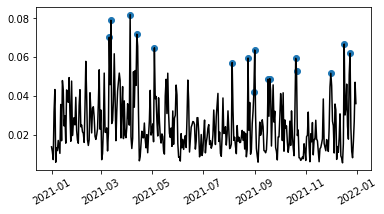

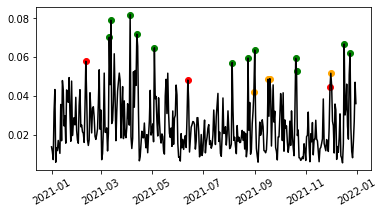

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


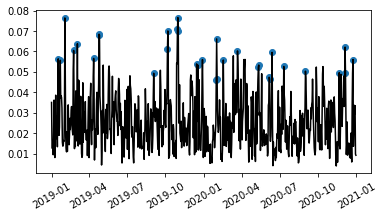

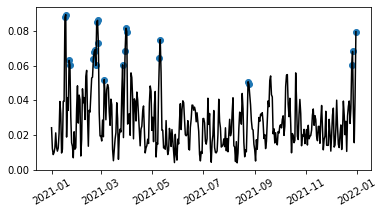

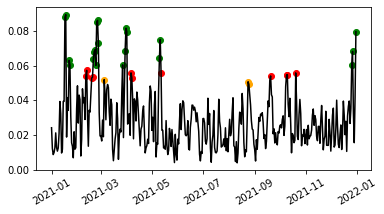

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


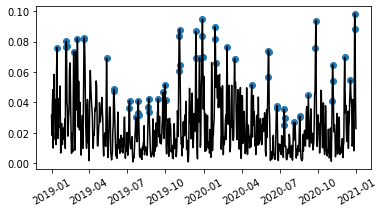

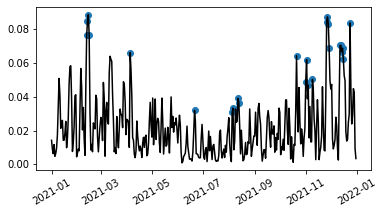

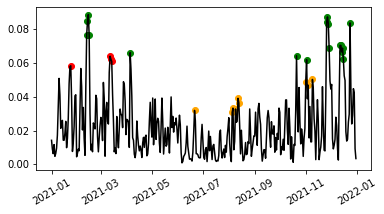

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


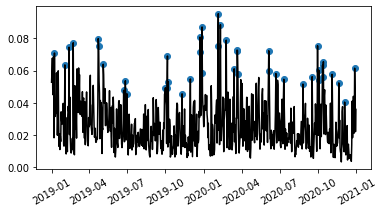

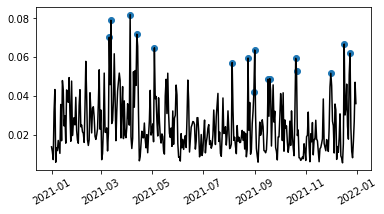

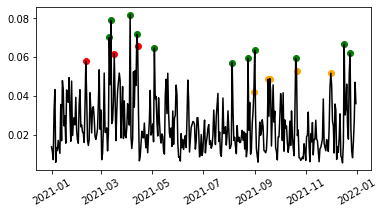

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


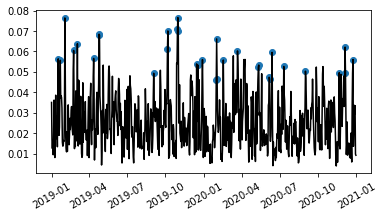

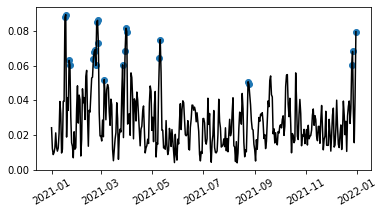

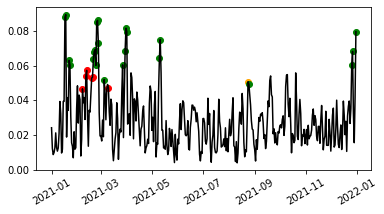

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


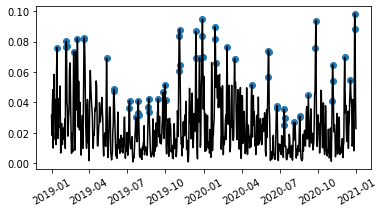

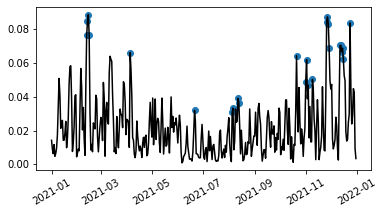

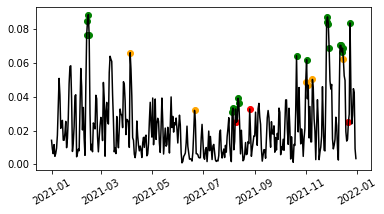

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


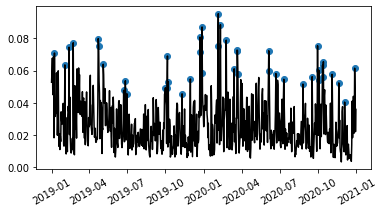

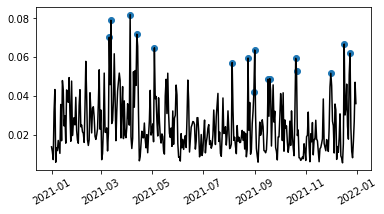

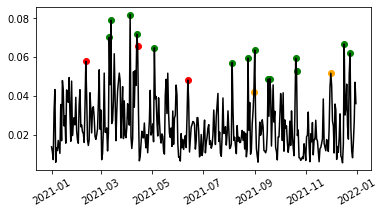

In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

scores = []
counts = []

for classifier in [KNeighborsClassifier(n_neighbors=1), GaussianNB(), DecisionTreeClassifier()]:
  for parameter in ["temperature", "pressure", "wind speed"]:
  # for parameter in ["pressure"]:
    dates, preds, labels, score = detect_anomalies(data, parameter, fun, classifier, True)
    scores.append(score)
    counts.append(sum(labels))
# plt.figure(figsize=(8,6))  
# plot_tree(classifier, fontsize=8, max_depth=2)
# plt.show()

In [42]:
for i in range(3):
  print([round(x, 2) for x in scores[3*i:3*i+3]])
for i in range(3):
  print(counts[3*i:3*i+3])

[0.82, 0.81, 0.77]
[0.74, 0.72, 0.73]
[0.86, 0.82, 0.85]
[23, 26, 16]
[23, 26, 16]
[23, 26, 16]


In [43]:
for i in range(3):
  print([round(x, 2) for x in scores[3*i:3*i+3]])
for i in range(3):
  print(counts[3*i:3*i+3])

[0.82, 0.81, 0.77]
[0.74, 0.72, 0.73]
[0.86, 0.82, 0.85]
[23, 26, 16]
[23, 26, 16]
[23, 26, 16]


In [44]:
def lcss(epsilon):
  return lambda x,y: 1 - metrics.lcss(x, y, eps=epsilon)

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)
<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


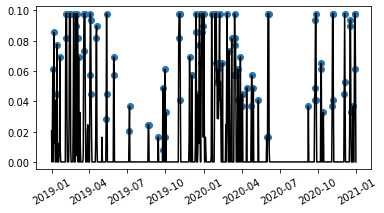

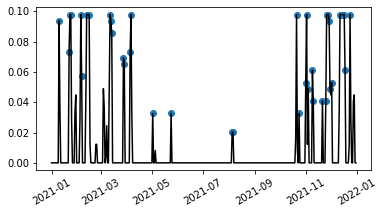

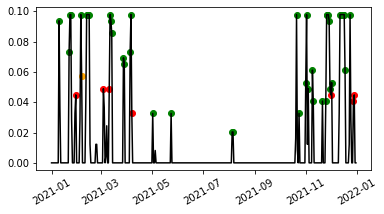

0.9148936170212766
44


<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


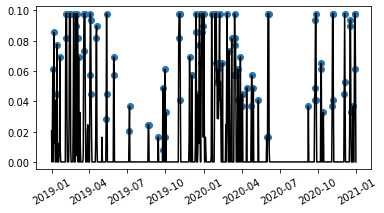

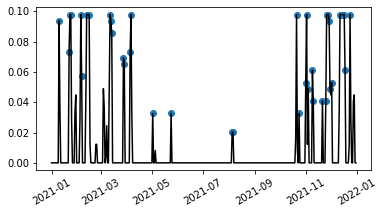

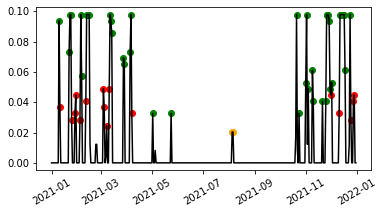

0.823529411764706
44


<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


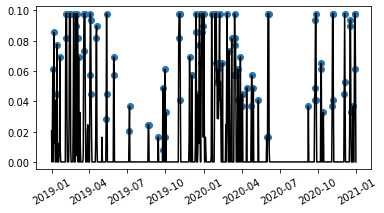

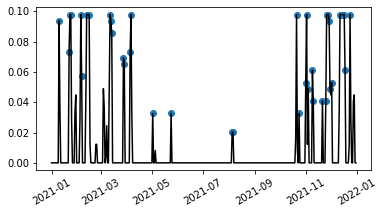

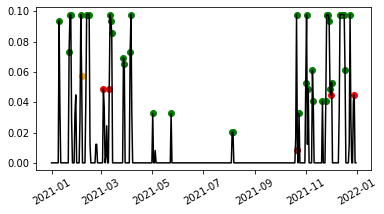

0.9347826086956522
44


In [45]:
#Epsilon wymaga ustalenia w zależności od parametru temp=2, pres=300, wind=1
parameter = "pressure"
fun = lcss(1100)
for classifier in [KNeighborsClassifier(n_neighbors=1), GaussianNB(), DecisionTreeClassifier()]:
  dates, preds_lcss, labels_lcss, score_lcss = detect_anomalies(data, parameter, fun, classifier, True)
  print(score_lcss)
  print(sum(labels_lcss))

Porównanie anomalii wykrytych na podstawie różnych miar odległości - jaki odsetek anomalii dla miary "a" był też anomalią dla miary "b"

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter = "pressure"
classifier = DecisionTreeClassifier()
predictions = []

for fun in [distance.euclidean, lcss(1100), metrics.dtw_path, ddtw]:
  dates, preds, labels, score = detect_anomalies(data, parameter, fun, classifier, False)
  predictions.append(preds)

<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)
<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)
<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)
<ipython-input-39-bc20dba9509f>:40: UserWarning: Discarding nonzero nanoseconds in conversion
  series, result_temp = sliding_mean_analysis(data, parameter, fun, 14)


In [47]:
for a in predictions:
  for b in predictions:
    matching = round(sum([a_val*b_val for a_val, b_val in zip(a, b)])/sum(a), 2)
    print(matching)
  print("\n")

matching = [i for i, x in enumerate(zip(*predictions)) if x[0]*x[1]*x[2]*x[3] > 0]
print(matching)

1.0
0.74
0.87
0.04


0.35
1.0
0.33
0.15


1.0
0.8
1.0
0.05


0.05
0.35
0.05
1.0


[293]


<ipython-input-48-18cda57a6be3>:1: UserWarning: Discarding nonzero nanoseconds in conversion
  series_pairs, distances = sliding_mean_analysis(data, parameter, distance.euclidean, 14)


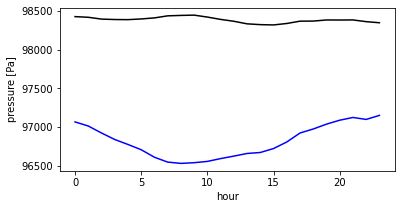

In [48]:
series_pairs, distances = sliding_mean_analysis(data, parameter, distance.euclidean, 14)
plot_path(series_pairs[365+366+293], None, parameter, "Pa", False)